## Library Import

In [83]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras #type: ignore
from tensorflow.keras import layers #type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer #type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from tensorflow.keras import callbacks #type: ignore

## Dataset Import

In [84]:
df = pd.read_csv("../../data/sms_with_features.csv")


## Data Preprocessing

In [85]:
df.isnull().sum().sum()
df.duplicated().sum()
df.drop_duplicates()


,label,message,char_count,word_count,num_count,has_url,has_email,has_currency,upper_ratio,special_count
0,ham,"Go until jurong point, crazy.. Available only ...",111,20,0,0,0,0,0.027027,0
1,ham,Ok lar... Joking wif u oni...,29,6,0,0,0,0,0.068966,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,25,0,0,0,0.064516,0
3,ham,U dun say so early hor... U c already then say...,49,11,0,0,0,0,0.040816,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,13,0,0,0,0,0.032787,0
...,...,...,...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160,30,21,0,0,1,0.056250,1
5568,ham,Will ü b going to esplanade fr home?,36,8,0,0,0,0,0.027778,1
5569,ham,"Pity, * was in mood for that. So...any other s...",57,10,0,0,0,0,0.035088,1
5570,ham,The guy did some bitching but I acted like i'd...,125,26,0,0,0,0,0.016000,0


## label Encoding （spam/ham → 0/1）


In [ ]:

text_col = "message"    
label_col = "label"    

# Delete Missing Value
df = df.dropna(subset=[text_col, label_col])

df["label_encoded"] = df[label_col].map({ "ham": 0, "spam": 1})


## Data Split 

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    df[text_col],
    df["label_encoded"],
    test_size=0.2,
    random_state=42
)


## Tokenizer (text to vector)


In [ ]:
# =============================
vocab_size = 10000   # Dictionary Size(10000 most common words)
maxlen = 100          # Each message maximum keep how many text nessage

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequence length
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')


## Construct LSTM model

In [89]:
model = keras.Sequential([
    layers.Embedding(vocab_size, 128, input_length=maxlen),
    layers.Bidirectional(layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])


c:\Degree\Machine Learning\Machine Learning Lab\assignment\Deep Learning Model\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Optimizer and Loss Function

In [90]:

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


## Train Model

In [ ]:
model.summary()
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

history = model.fit(
    X_train_pad,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2, 
    callbacks=[early_stopping],
    verbose=1
)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - accuracy: 0.9229 - loss: 0.2342 - val_accuracy: 0.9742 - val_loss: 0.0830 - learning_rate: 0.0010
Epoch 2/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.9888 - loss: 0.0423 - val_accuracy: 0.9821 - val_loss: 0.0753 - learning_rate: 0.0010
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - accuracy: 0.9966 - loss: 0.0151 - val_accuracy: 0.9809 - val_loss: 0.0864 - learning_rate: 0.0010
Epoch 4/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.9989 - loss: 0.0053 - val_accuracy: 0.9832 - val_loss: 0.0954 - learning_rate: 0.0010


## Evaluate Model

In [98]:
from sklearn.metrics import confusion_matrix, classification_report
loss, acc = model.evaluate(X_test_pad, y_test)
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)
print(f"Test Accuracy: {acc:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9901 - loss: 0.0401
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Test Accuracy: 0.9901


In [99]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.99      0.94      0.96       149

    accuracy                           0.99      1115
   macro avg       0.99      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



## Visualization

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

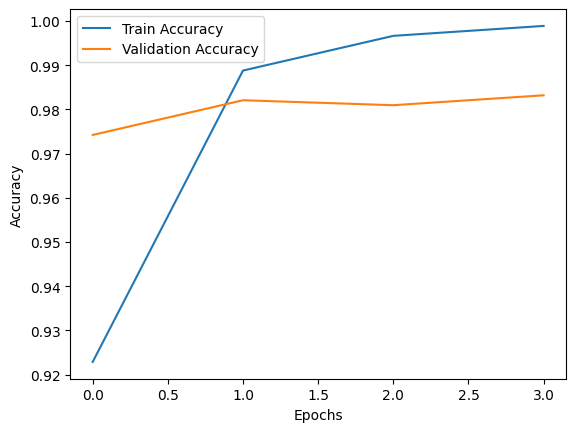

In [94]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


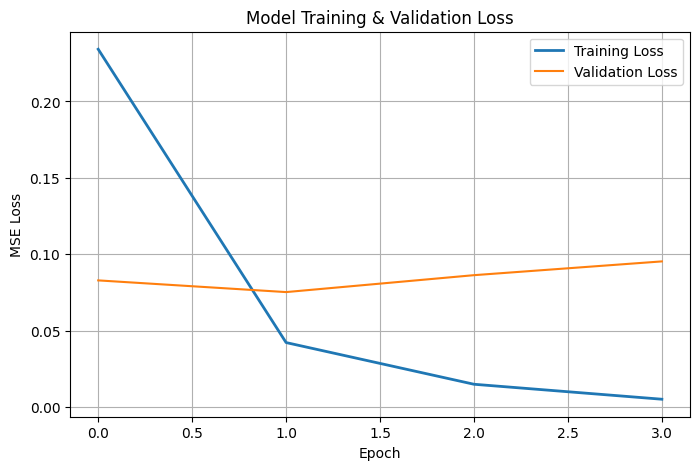

In [95]:
# Viszualization Training Procedure
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Training Loss", linewidth=2)
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title('Model Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

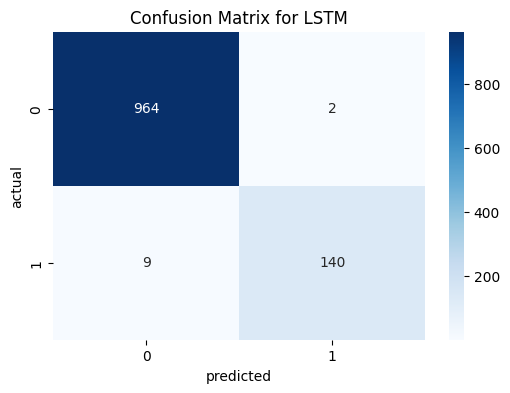

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), annot=True, fmt="d", cmap='Blues')
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("Confusion Matrix for LSTM")
plt.show()